In [1]:
import pandas as pd
from astropy.io import fits
import numpy as np
from PIL import Image

import os

import torch
import torch.nn as nn
from torch.functional import F

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

from auxiliar import *

In [2]:
torch.cuda.is_available()

True

In [3]:
class AstroDataset(Dataset):
    def __init__(self, csv_file, images_dir):
        self.df = pd.read_csv(csv_file)
        self.images_dir = images_dir

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.df.iloc[idx, 0] + '.fits.fz')
        image_data = fits.getdata(img_name)

        # Assuming image_data is 2D, add a channel dimension and convert to float
        image_data = torch.tensor(image_data, dtype=torch.float).unsqueeze(0)
        
        # Normalize the image data if necessary
        # image_data = (image_data - image_data.mean()) / image_data.std()

        label = self.df.iloc[idx, 1]  # Assuming the label is in the second column
        label = torch.tensor(label, dtype=torch.float)

        return image_data, label

    def __len__(self):
        return len(self.df)
    

In [14]:
astro_dataset = AstroDataset(csv_file='data.csv', images_dir='data/')

train_size = int(0.8 * len(astro_dataset))
val_size = len(astro_dataset) - train_size

train_dataset, val_dataset = random_split(astro_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=12)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=12)

tensor(0.5755)


TypeError: Invalid shape (1, 250, 250) for image data

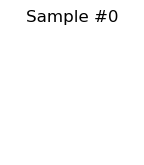

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure()

for i, sample in enumerate(astro_dataset):
    print(sample[1])
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plot_fits(sample[0])

    if i == 3:
        plt.show()
        break

In [15]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 59 * 59, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 59 * 59)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

In [16]:
net = ConvNet()

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net.to(device) # Move your model to the appropriate device


ConvNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=55696, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)

In [18]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = ConvNet().to(device)
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        print(outputs.squeeze(), labels)
        loss = criterion(outputs.squeeze(), labels)  # Squeeze outputs to match label dimensions
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0